In [1]:
import Bio.PDB
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt 
import seaborn as sns
sns.set_theme()

In [2]:
pdb_file = Path("/Users/matthew/Documents/mtorc2/data/pdb/MTORC2.rigid_body.pdb")
intra_xl_file = Path(Path.home(), "Documents/mtorc2/data/xlms/intra.csv")
inter_xl_file = Path(Path.home(), "Documents/mtorc2/data/xlms/inter.csv")


In [3]:
aas = ["ALA", "ARG", "ASN", "ASP", "CYS", "GLU", "GLN", "GLY", "HIS", "ILE", "LEU", "LYS", "MET", "PHE", "PRO", "SER", "THR", "TRP", "TYR", "VAL"]
pdb_parser = Bio.PDB.PDBParser(QUIET=True)
model = pdb_parser.get_structure("reference", str(pdb_file))[0]


In [4]:
chain_ids = dict() 
chain_ids["MTOR"] = "A"
chain_ids["RICTOR"] = "B"
chain_ids["MLST8"] = "C"
chain_ids["MTOR_B"] = "D"
chain_ids["RICTOR_B"] = "E"
chain_ids["MLST8_B"] = "F"
chain_ids["MSIN1"] = "G"
chain_ids["MSIN1_B"] = "H"


In [5]:
chains = dict() 
for chain in model:
    chains[chain.id] = chain

In [6]:
print(chains)

{'A': <Chain id=A>, 'B': <Chain id=B>, 'C': <Chain id=C>, 'G': <Chain id=G>}


In [7]:
xls_df = pd.read_csv(inter_xl_file)
xls_df = pd.concat([xls_df, pd.read_csv(intra_xl_file)], axis=0)
xls_df.head()

,Unnamed: 0,prot1,res1,prot2,res2
0,0,MTOR,1197,RICTOR,516
1,1,MTOR,1218,RICTOR,516
2,2,RICTOR,1642,MSIN1,102
3,3,RICTOR,1092,MTOR,1993
4,4,RICTOR,1642,MSIN1,104


In [8]:
xls_df['contains'] = False
xls_df['satisfied'] = False
xls_df.head()

,Unnamed: 0,prot1,res1,prot2,res2,contains,satisfied
0,0,MTOR,1197,RICTOR,516,False,False
1,1,MTOR,1218,RICTOR,516,False,False
2,2,RICTOR,1642,MSIN1,102,False,False
3,3,RICTOR,1092,MTOR,1993,False,False
4,4,RICTOR,1642,MSIN1,104,False,False


In [9]:
# Remove any duplicate entries.
duplicates = list() 
for i in range(len(xls_df)): 
    prot1 = xls_df.iloc[i, xls_df.columns.get_loc("prot1")]
    prot2 = xls_df.iloc[i, xls_df.columns.get_loc("prot2")]
    res1 = xls_df.iloc[i, xls_df.columns.get_loc("res1")]
    res2 = xls_df.iloc[i, xls_df.columns.get_loc("res2")]
    
    for j in range(i+1, len(xls_df)): 
        cur_prot1 = xls_df.iloc[j, xls_df.columns.get_loc("prot1")]
        cur_prot2 = xls_df.iloc[j, xls_df.columns.get_loc("prot2")]
        cur_res1 = xls_df.iloc[j, xls_df.columns.get_loc("res1")]
        cur_res2 = xls_df.iloc[j, xls_df.columns.get_loc("res2")]
        
        if prot1 == cur_prot1 and prot2 == cur_prot2 and res1 == cur_res1 and res2 == cur_res2: 
            duplicates.append((i,j))
        elif prot1 == cur_prot2 and prot2 == cur_prot1 and res1 == cur_res2 and res2 == cur_res1:
            duplicates.append((i,j))

            

In [10]:
xls_df = xls_df.reset_index()
xls_df = xls_df.drop(columns=["Unnamed: 0"])
xls_df = xls_df.drop(columns=["index"])

In [11]:
xls_df = xls_df.drop([second for first, second in duplicates])
xls_df.tail()

,prot1,res1,prot2,res2,contains,satisfied
213,MTOR,298,MTOR,309,False,False
214,AKT1,140,AKT1,214,False,False
215,MTOR,980,MTOR,1256,False,False
217,MTOR,309,MTOR,2370,False,False
218,RICTOR,1092,RICTOR,1107,False,False


In [12]:
# Flip MTOR so that it is always prot1. 
for i in range(len(xls_df)): 
    if xls_df.iloc[i, xls_df.columns.get_loc("prot2")] == "MTOR": 
        prot1_copy = xls_df.iloc[i, xls_df.columns.get_loc("prot1")]
        res1_copy = xls_df.iloc[i, xls_df.columns.get_loc("res1")]
        
        xls_df.iloc[i, xls_df.columns.get_loc("prot1")] = xls_df.iloc[i, xls_df.columns.get_loc("prot2")]
        xls_df.iloc[i, xls_df.columns.get_loc("res1")] = xls_df.iloc[i, xls_df.columns.get_loc("res2")]

        xls_df.iloc[i, xls_df.columns.get_loc("prot2")] = prot1_copy
        xls_df.iloc[i, xls_df.columns.get_loc("res2")] = res1_copy


In [13]:
print(len(xls_df))

200


In [14]:
xls_df["copy"] = "A"
xls_df.head()

,prot1,res1,prot2,res2,contains,satisfied,copy
0,MTOR,1197,RICTOR,516,False,False,A
1,MTOR,1218,RICTOR,516,False,False,A
2,RICTOR,1642,MSIN1,102,False,False,A
3,MTOR,1993,RICTOR,1092,False,False,A
4,RICTOR,1642,MSIN1,104,False,False,A


In [15]:
cutoff = 35
dimer = False
for i in range(len(xls_df)): 
    prot1 = xls_df.iloc[i]["prot1"]
    prot2 = xls_df.iloc[i]["prot2"]
    res1 = int(xls_df.iloc[i]["res1"])
    res2 = int(xls_df.iloc[i]["res2"])

    if prot1 == "AKT1" or prot2 == "AKT1": 
        continue
#     if prot1 == "MSIN1" or prot2 == "MSIN1": 
#         continue
        
    # Check if contains. 
    chain1 = chains[chain_ids[prot1]]
    chain2 = chains[chain_ids[prot2]]
    
    if dimer: 
        chain2_alt = chains[chain_ids[prot2+"_B"]]
    if chain1.__contains__(res1) and chain2.__contains__(res2): 
        # Check if satisfied. 
        xls_df.iloc[i, xls_df.columns.get_loc('contains')] = True
        pos1 = chain1.__getitem__(res1)['CA'].coord
        pos2 = chain2.__getitem__(res2)['CA'].coord
        l2norm = np.linalg.norm(pos1 - pos2)
        if l2norm < cutoff: 
#             print(prot1, prot2, res1, res2, l2norm)
            xls_df.iloc[i, xls_df.columns.get_loc('satisfied')] = True
        
        if dimer: 
            # Check if alternative location satisfies.
            pos2_alt = chain2_alt.__getitem__(res2)['CA'].coord
            l2norm_alt = np.linalg.norm(pos1 - pos2_alt)

            if l2norm_alt < l2norm: 
                xls_df.iloc[i, xls_df.columns.get_loc('copy')] = "B" 

                if l2norm_alt < cutoff: 
                    xls_df.iloc[i, xls_df.columns.get_loc('satisfied')] = True

            print(prot1, prot2, res1, res2, l2norm, l2norm_alt)

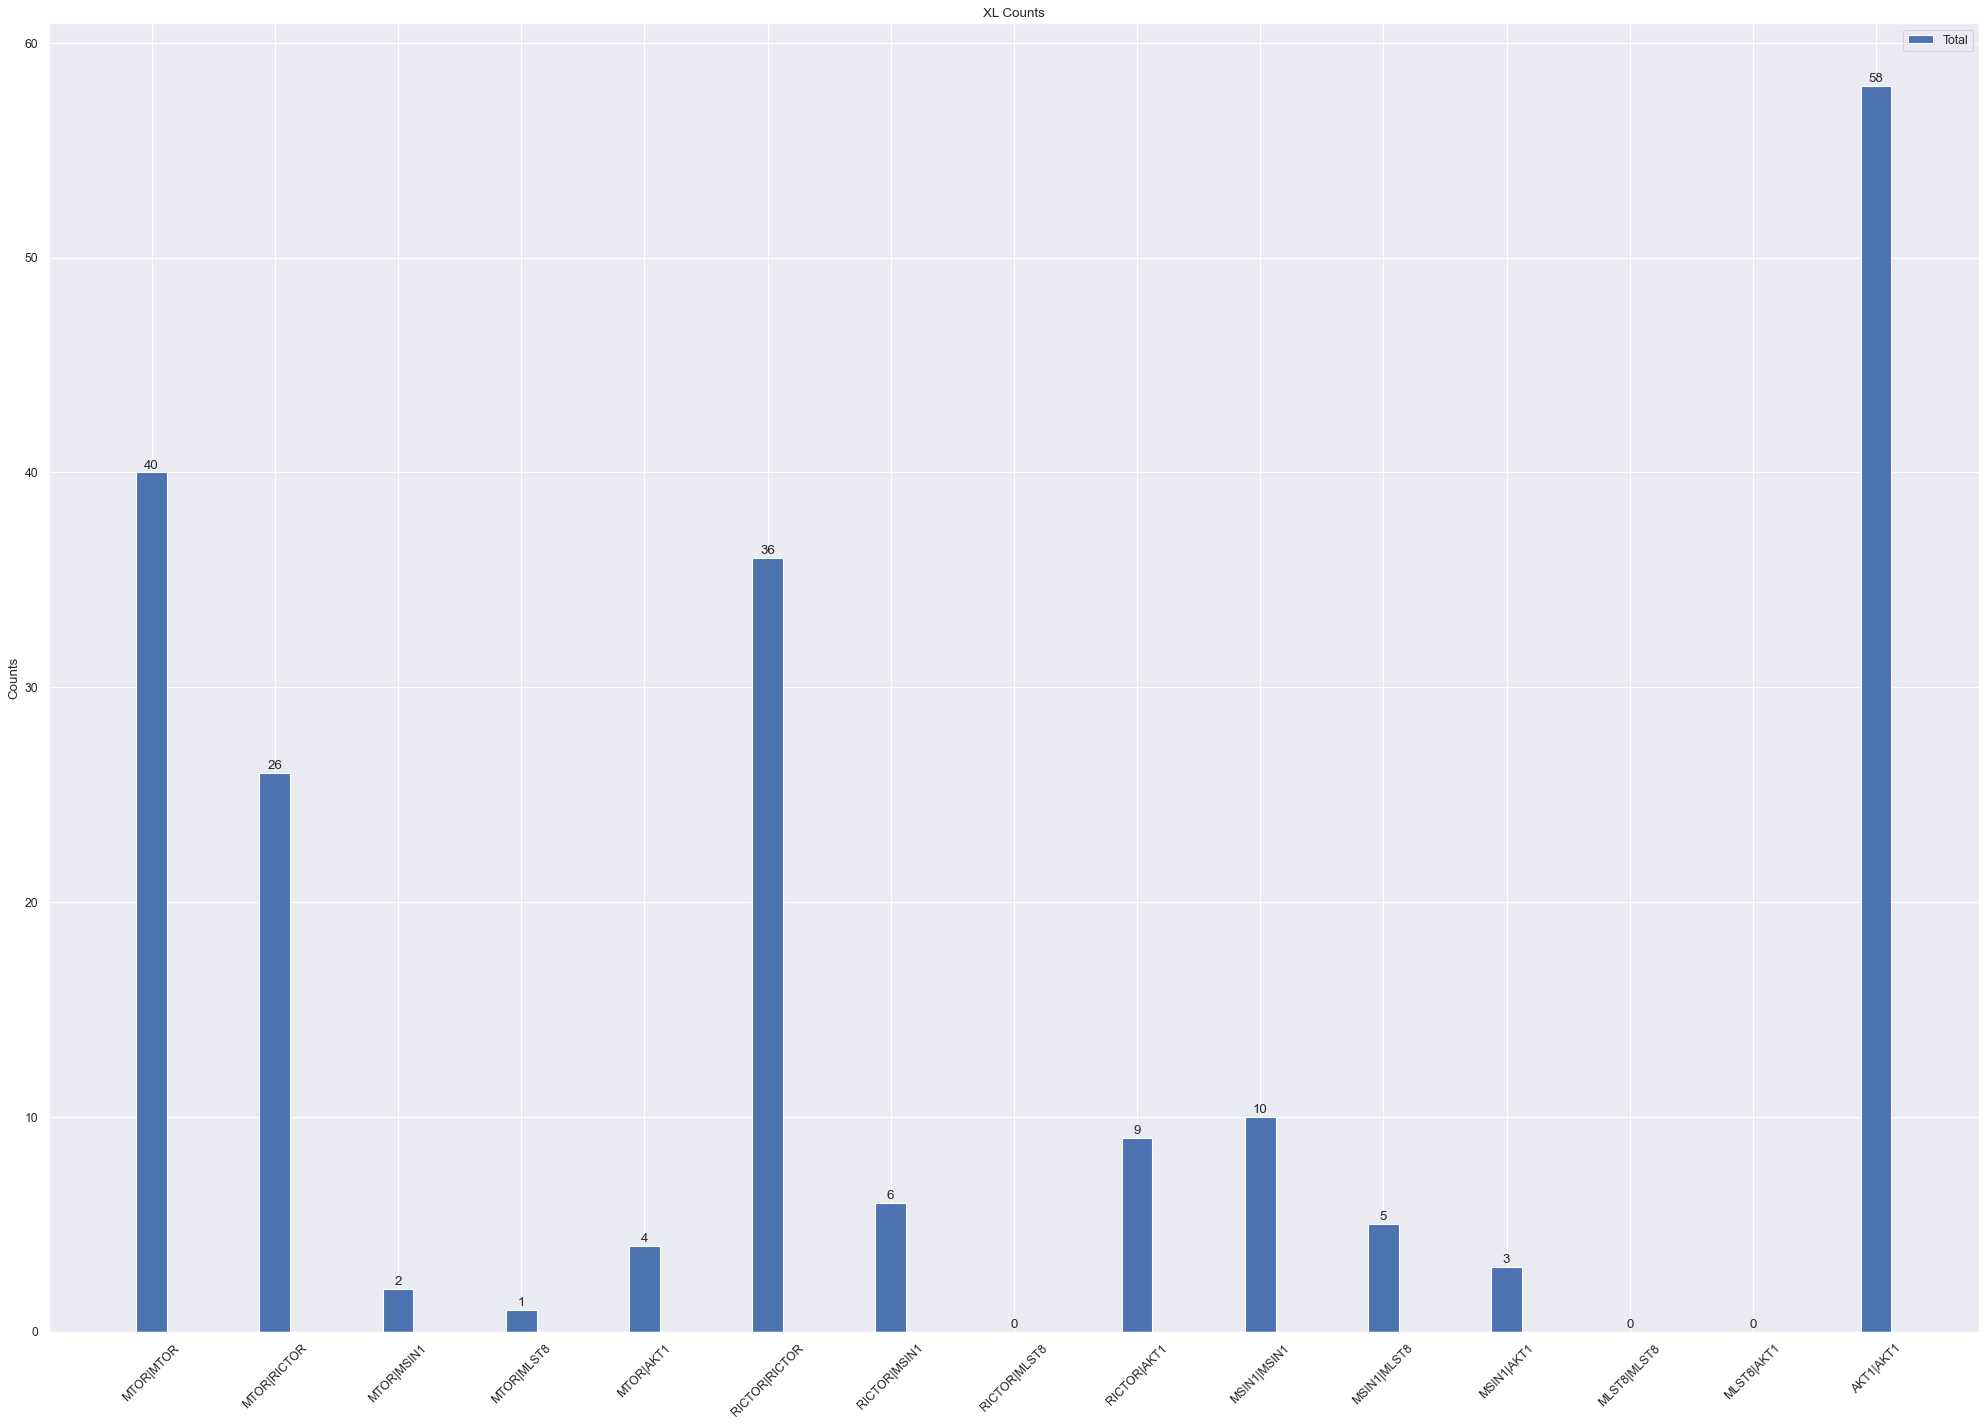

In [23]:
n_contains = dict()
n_satisfied = dict() 
n_xls = dict() 

prots = ["MTOR", "RICTOR", "MSIN1", "MLST8", "AKT1"]
for prot in prots: 
    for prot2 in prots: 
        entry = prot + "|" + prot2
        if prot2 + "|" + prot not in n_contains.keys(): 
            n_contains[entry] = 0
            n_satisfied[entry] = 0
            n_xls[entry] = 0

for i in range(len(xls_df)): 
    prot1 = xls_df.iloc[i, xls_df.columns.get_loc('prot1')]
    prot2 = xls_df.iloc[i, xls_df.columns.get_loc('prot2')]
    
    entry = prot1 + "|" + prot2
    if entry not in n_contains.keys(): 
        entry = prot2 + "|" + prot1

    n_xls[entry] = n_xls[entry] + 1

    if xls_df.iloc[i, xls_df.columns.get_loc('contains')]: 
        n_contains[entry] = n_contains[entry] + 1
        
    if xls_df.iloc[i, xls_df.columns.get_loc('satisfied')]:
        n_satisfied[entry] = n_satisfied[entry] + 1 
        
fig, ax = plt.subplots(figsize=(25, 18), dpi=80) 
labels = list(n_contains.keys())
contains_list = [n_contains[key] for key in n_contains.keys()]
satisfied_list = [n_satisfied[key] for key in n_contains.keys()]
n_xls_list = [n_xls[key] for key in n_contains.keys()]

x = np.arange(len(labels))  # the label locations
width = .75  # the width of the bars

rects3 = ax.bar(x, n_xls_list, width/3, label='Total')
# rects1 = ax.bar(x + width/3, contains_list, width/3, label='Contains')
# rects2 = ax.bar(x + 2*width/3, satisfied_list, width/3, label='Satisfied')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Counts')
ax.set_title('XL Counts')
ax.set_xticks(x, labels)
ax.set_xticklabels(labels, rotation=45)
ax.legend()

# ax.bar_label(rects1, padding=1)
# ax.bar_label(rects2, padding=1)
ax.bar_label(rects3, padding=1)

fig.tight_layout()
# plt.show()
plt.savefig("/Users/matthew/Desktop/plot.png")

In [42]:
sat_xls, unsat_xls = "", ""
for i in range(len(xls_df)): 
    if xls_df.iloc[i, xls_df.columns.get_loc("contains")]: 
        if xls_df.iloc[i, xls_df.columns.get_loc("satisfied")]: 
            color="green"
        else: 
            color="red"
        
        
        res1 = xls_df.iloc[i, xls_df.columns.get_loc("res1")]
        res2 = xls_df.iloc[i, xls_df.columns.get_loc("res2")]
        
        chain1 = chain_ids[xls_df.iloc[i, xls_df.columns.get_loc("prot1")]]
        chain2 = chain_ids[xls_df.iloc[i, xls_df.columns.get_loc("prot2")]]
        
        if xls_df.iloc[i, xls_df.columns.get_loc("copy")] == "B": 
            chain2 = chain_ids[xls_df.iloc[i, xls_df.columns.get_loc("prot2")]+"_B"]
        
        pb_str = "#1/{}:{}@CA #1/{}:{}@CA\n".format(chain1, res1, chain2, res2)
        if xls_df.iloc[i, xls_df.columns.get_loc("satisfied")]: 
            sat_xls = sat_xls + pb_str 
        else: 
            unsat_xls = unsat_xls + pb_str

            
print("green")
print(sat_xls)
print("red")
print(unsat_xls)
#         print("#0:{}.{}@CA #0:{}.{}@CA {}".format(res1, chain1, res2, chain2, color))

green
#1/B:1642@CA #1/G:102@CA
#1/B:1642@CA #1/G:104@CA
#1/G:95@CA #1/B:1614@CA
#1/A:2374@CA #1/C:86@CA
#1/A:2113@CA #1/B:274@CA
#1/G:132@CA #1/C:322@CA
#1/A:2113@CA #1/B:270@CA
#1/A:2218@CA #1/A:900@CA
#1/B:791@CA #1/B:813@CA
#1/B:764@CA #1/B:800@CA
#1/B:791@CA #1/B:826@CA
#1/A:1745@CA #1/A:1655@CA
#1/B:374@CA #1/B:734@CA
#1/B:541@CA #1/B:582@CA
#1/B:800@CA #1/B:856@CA
#1/B:800@CA #1/B:734@CA
#1/B:921@CA #1/B:856@CA
#1/A:1293@CA #1/A:1267@CA
#1/B:692@CA #1/B:719@CA
#1/B:239@CA #1/B:916@CA
#1/B:374@CA #1/B:800@CA
#1/B:764@CA #1/B:856@CA
#1/A:226@CA #1/A:1277@CA
#1/A:900@CA #1/A:2352@CA
#1/A:1406@CA #1/A:2301@CA
#1/A:2090@CA #1/A:2045@CA
#1/A:2370@CA #1/A:2166@CA
#1/A:226@CA #1/A:1566@CA
#1/G:102@CA #1/G:95@CA
#1/A:84@CA #1/A:128@CA
#1/A:1662@CA #1/A:898@CA
#1/B:764@CA #1/B:791@CA
#1/A:230@CA #1/A:1277@CA
#1/A:1655@CA #1/A:1702@CA
#1/A:1471@CA #1/A:1500@CA
#1/A:1655@CA #1/A:898@CA
#1/B:699@CA #1/B:734@CA
#1/B:781@CA #1/B:813@CA
#1/B:838@CA #1/B:856@CA
#1/A:1868@CA #1/A:1805@CA
#1/A:2218